# **Градиентный спуск и методы его оптимизации**
<a id = 'top'></a>

### ***Содержание***

* 1. [Введение](#intro)
* 2. [Градиентный спуск в рамках матанализа](#grad_desc_in_math)
  * 2.1. [Условие задачи](#task_descrip)
  * 2.2. [Функция потерь](#loss_func)
  * 2.3. [Градиентный спуск](#basics_grad_desc)
  * 2.4. [Математическая интерпретация функции потерь](#math_loss_func)
* 3. [Градиентный спуск в рамках машинного обучения](#grad_desc_in_ml)
  * 3.1. [Пример реализации batch-градиентного спуска](#batch_grad_desc_code_examp)
  * 3.2. [Недостатки градиентного спуска](#grad_desc_disadvantages)
      * 3.2.1. [Нахождение ложного локального минимума](#wrong_min_error)
      * 3.2.2. [Высокая асимптотика алгоритма](#high_asimptotics)
* 4. [Методы оптимизации градиентного спуска](#batch_grad_desc_optimize)
  * 4.1. [Определение начальной координаты](#start_coord)
  * 4.2. [Метод нормирования градиента (clip gradient)](#clip_grad)
  * 4.3. [Цикл `while`](#while_grad_desc)
  * 4.4. [Стохастический градиентный спуск](#stoch_grad_desc)
* 5. Задача аппроксимации линейной функции
  * 5.1. Условие задачи
  * 5.2. Алгебраическое решение
  * 5.3. Решение с помощью batch-градиентного спуска
  * 5.4. Оптимизированное решение с помощью стохастического градиентного спуска
* 6. Заключение

## **Введение**
<a id='intro'></a>
[**Вернуться к содержанию**](#top)

Большинство задач машинного обучения, как правило, представляют собой задачи или классификации, или регрессии. Ярким примером задач последнего типа является задача аппроксимации линейной функции.

Ниже будет рассмотрено применение самого популярного метода оптимизации для решения данной задачи. Речь пойдёт о градиентном спуске и методах его оптимизации.

*Примечание: в данном документе будут встречаться программные коды. Они будут написаны на языке `Python` с использованием библиотеки `PyTorch`.*

## **Градиентный спуск в рамках матанализа**
<a id='grad_desc_in_math'></a>
[**Вернуться к содержанию**](#top)

### Условие задачи
<a id='task_descrip'></a>

Рассмотрим группу точек на двумерной плоскости. Предположим, что данные связаны с ростом и весом группы студентов. Мы пытаемся предсказать какую-то связь между этими величинами, чтобы впоследствии предсказать вес некоторых новых студентов. Это, по сути, простой пример контролируемого машинного обучения.

Проведем произвольную прямую в пространстве, которая пересекает некоторые точки. Уравнение этой прямой: $y = kx + b$, где $k$ - коэффициент угла наклона, а $b$ - перемещение по оси $Oy$ (см. *Рис. 1*).

***Рис. 1: Задача аппроксимации линейной функции***
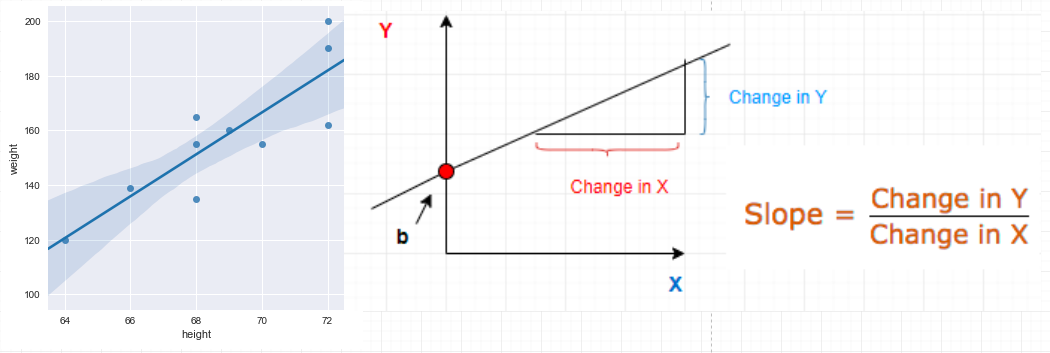

Учитывая уже известный набор входных данных (в нашем случае $x$-координаты) и соответствующие им выходные данные ($y$-координаты), модель пытается сделать прогнозы для нового набора входных данных (см. *Рис. 2*).

***Рис. 2: Схема модели машинного обучения***

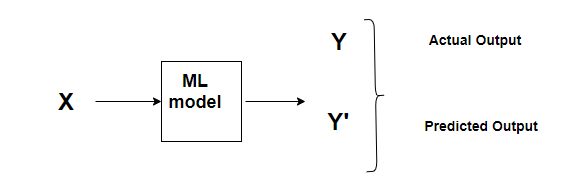

### Функция потерь (MSE)
<a id='loss_func'></a>

Однако возникает вопрос: насколько "хороша" модель, иначе говоря, насколько точное сравнительно с реальностью предсказание она сделала? Логично предположить, что данный вопрос решается тривиально:

$MSE = \frac{\sum_{i=1}^{N} (Y'_i - Y_i)^2}{N}$, где $N$ - кол-во точек, $Y'_i$ - предсказанное значение, а $Y_i$ - входное значение.

В машинном обучении такие функции называются **функции потерь** или **функции стоимости** (сделаем допущение: функция потерь и функция стоимости - равнозначные термины). В данноми случае мы используем разновидность функции потерь, которая называется **MSE** (Mean Squared Error) -- среднеквадратичная ошибка.

**Цель** практически любого алгоритма машинного обучения - **минимизировать функцию потерь**.

Функция потерь предназначена для отслеживания ошибки с каждым примером обучениям, в то время как производная функции относительного одного веса – это то, куда нужно сместить вес, чтобы минимизировать ее для этого примера обучения.

Стоит отдельно рассмотреть вопрос, почему функция потерь среднеквадратичная, а не абсолютная. Дело в том, что квадрат разности значений облегчает процесс оптимизации. Действительно, чтобы оптимизировать функцию под определённые значения, нужно вычислить первую производную функции стоимости, а вычислить производную от абсолютных значений гораздо сложнее, нежели от квадратов. Кроме того, квадрат разности увеличивает различие ошибки, таким образом, делая неверные предсказания более выраженными, чем верные.

Рассмотрим график функции $y = x^2$ в декартовой системе координат (см. *Рис. 3*).

***Рис. 3: График функции $y = x^2$***

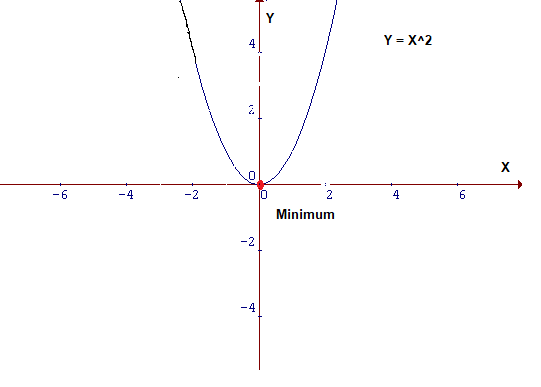

Чтобы достичь минимума функции, необходимо найти такое значение $x$, чтобы значение $y$ было минимально (красная точка на *Рис. 3*).

Исходя из двумерности графика на *Рис. 3*, найти минимум функции не составляет труда. Однако функция далеко не всегда может располагаться в двумерном пространстве, что значительно усложняет процесс нахождения минимума. И именно в таких случаях в целях нахождения минимума функции применяется алгоритм, несущий название **градиентный спуск**.

### Градиентный спуск
<a id='basics_grad_desc'></a>

Градиентный спуск - итеративный алгоритм оптимизации, применяющийся в большинстве случаев при оптимизации весов нейронной сети.

***Рис. 4: Возможные варианты спуска***

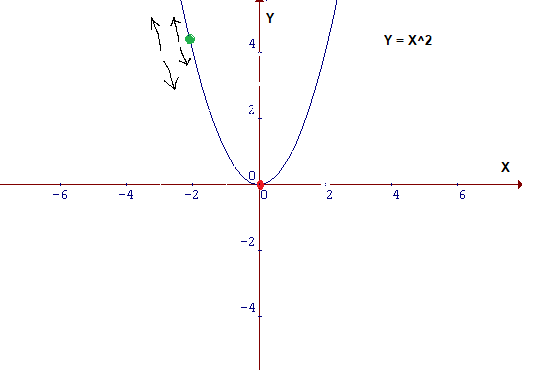

Рассмотрим *Рис. 4*. Представим, что мы находимся в зелёной точке и хотим спустится с холма в низину. Для достижения нашей цели следует определиться с двумя вопросами:

* в какую сторону идти (влево или вправо);
* как идти (короткими или длинными шагами).

Для решения этих вопросов в алгоритме градиентного спуска используются производные. Таким образом, если в точке $x$ существует производная, то существует и направление, при движении в котором алгоритм достигнет минимума.

Рассмотрим *Рис. 5*.

Пусть, касательные, проведённые через зелёную и синию точки, обозначаются $a$ и $b$ соответственно. Тогда можно обратить внимание на различный угол наклона касательных: несмотря на то, что обе касательные идут в одном направлении (вниз), угол наклона $a$ к графику функции более "крутой", чем угол наклона $b$. Из этого следует, что для достижения локального минимума из синей точки понадобиться сделать **строго меньше шагов**, чем из зелёной точки.

***Рис. 5: Касательные к графику $y = x^2$***

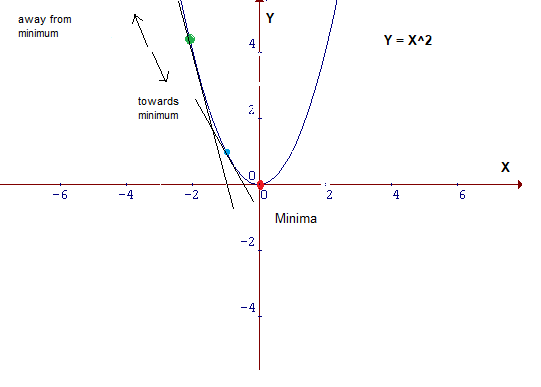

### Математическая интерпретация функции потерь
<a id='math_loss_func'></a>

В течение градиентного спуска параметры функции $y = kx + b$ ($k$ и $b$) изменяются на какое-то значение. Пусть это значение будет $\beta$. Тогда:

$k_1 = k_0 - \beta k_0, b_1 = b_0 - \beta b_0$ (1) ->

-> $MSE = \frac{\sum_{i=1}^{N} (Y'_i - Y_i)^2}{N}$ ->

-> $J(k, b) = \frac{\sum_{i=1}^{N} (Y'_i - Y_i)^2}{N}$ ->

-> $J(k, b) = \frac{\sum_{i=1}^{N} (MSE_i)^2}{N}, MSE_i = (Y'_i - Y_i)^2$ ->

-> ... ->

-> $\frac{dJ(k, b)}{dk} = MSE * x * \alpha,$

$\frac{dJ(k, b)}{db} = MSE * \alpha$, где $\alpha$ - коэффициент обучения, определяющий, какой длины нужно сделать шаг. ->

-> Так как (1) ->

-> $k_1 = k_0 - MSE * x * \alpha$

$b_1 = b_0 - MSE * \alpha$,

где $k_0, b_0$ - предыдущие значения параметров, а $k_1, b_1$ - следующие значения параметров.

## **Градиентный спуск в рамках машинного обучения**
<a id = 'grad_desc_in_ml'></a>
[**Вернуться к содержанию**](#top)

### Пример реализации batch-градиентного спуска
<a id = 'batch_grad_desc_code_examp'></a>

In [6]:
import torch


def batch_grad_desc(f, X0s: list, N=10001, alpha=.01, step=1) -> list:
    XMins = []                                                      # список для хранения минимумов
    for x0 in X0s:                                                  # цикл по x0 (координаты старта градиентного спуска)
        for _ in range(N):                                          # цикл по количеству шагов
            X = torch.tensor([x0],                                  # тензор X, содержащий x-координату текущей-
                             dtype=torch.float, requires_grad=True) # -точке с возможностью взятия производной
            y = f(X)                                                # функция от X
            y.backward()                                            # вычисляем производную по y
            x0 -= X.grad.item() * alpha * step                      # совершаем шаг, аппроксимируя x0
        XMins.append(x0)                                            # после прохода цикла предполагаемый минимум функции добавляется в список
    return XMins                                                    # возвращает список минимумов


f = lambda x: x**4 + x**3 - 1
X0s = [-20., -7., -5., 5., 7., 20.]
XMins = batch_grad_desc(f, X0s)
for x0, xmin in zip(X0s, XMins):
    print(f'при x0 = {x0}: x = {xmin}, y = {f(xmin)}')

при x0 = -20.0: x = nan, y = nan
при x0 = -7.0: x = -0.7500000286102306, y = -1.1054687499999991
при x0 = -5.0: x = -0.75, y = -1.10546875
при x0 = 5.0: x = -0.75, y = -1.10546875
при x0 = 7.0: x = nan, y = nan
при x0 = 20.0: x = nan, y = nan


### Недостатки градиентного спуска
<a id = 'grad_desc_disadvantages'></a>

#### Нахождение ложного локального минимума
<a id = 'wrong_min_error'></a>

Судя по выходным данным предыдущей ячейки кода, градиентному спуску не во всех случаях удалось найти минимум функции $y = x^4 + x^3 - 1$. При $x_0 = -7.0$ градиентный спуск нашёл истинный минимум функции. При $x_0 = -5.0; 5.0$ -- примерный минимум. Однако в остальных случаях ($x_0 = -20.0; 7.0; 20.0$) код вернул `nan`. Алгоритм градиентного спуска допустил ошибки по следующим причинам.

Сперва рассмотрим неточные минимумы при $x_0 = -5.0; 5.0$. Алгоритм вычислил примерный минимум функции. Когда такое случается, это говорит о том, что алгоритму либо не хватило шагов, чтобы достигнуть истинного минимума, либо шагов, напротив, было слишком много, и алгоритм перескочил через точку минимума функции. Эти проблемы обусловлены неверным выбором точки для началы градиентного спуска.

В остальных же случаях алгоритм градиентного спуска вернул `nan`. Это значит, что алгоритм **разошёлся**, произошло **расхождение**. Это значит, что шаг градиентного спуска был таковым, что мы перескочили точку предполагаемого минимума, вследствие чего лишь удалились от последней (см. *Рис. 6*).

***Рис. 6: Расхождение градиентного спуска ($y(x_0) < y(x_1)$)***

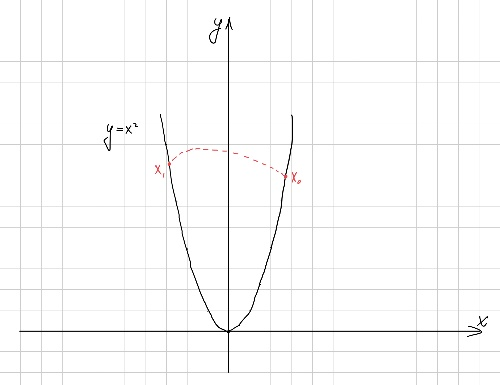

#### Высокая асимптотика алгоритма
<a id = 'high_asimptotics'></a>

Рассмотрим следующий пример: дана задача аппроксимировать линейную функцию $y = ksin(x) + b$. При этом дан набор *(batch)* точек, содержащий в себе 10 координат $x$ и 10 $y$: $[(0, 1), (1, 2), ..., (8, 9), (9, 10)]$.

Чтобы решить данную задачу воспользуемся градиентным спуском: будем аппроксимировать параметры (коэффициенты) $k$ и $b$ до тех пор, пока не достигнем минимума функции потерь.

На первый взгляд решённая нами задача не является трудной. Однако это так лишь до тех пор, пока количество входных данных (в нашем случае batch'ей) находится в границах допустимого. Но что, если вместо этих 10 пар значений будет дан датасет из 1000, 10000, или даже, как часто это бывает, из 10000 таких значений? Очевидно что вычислительная сложность нашего алгоритма станет слишком высокой, из-за чего время работы программы будет аналогично долгим.

Решения всех вышеперечисленных недостатков batch-градиентного спуска будут рассмотрены в следующей главе.

## **Методы оптимизации градиентного спуска**
<a id = 'batch_grad_desc_optimize'></a>
[**Вернуться к содержанию**](#top)

### Определение начальной координаты
<a id='start_coord'></a>

В тех случаях, когда функция, минимум которой требуется найти, представляет из себя полином вида $Ax^n + Bx^{n-1} + ... + Yx + Z$, за точку старта градиентного спуска можно взять минимум функции старшего члена полинома ($Ax^n$).

*Пример:* $y = 5x^8 - 3x^3 + x^2 - 12$.

В данном случае градиентный спуск следует начать с точки $x_0 = f_{min}, f = 5x^8$ --> $x_0 = 0$

### Метод нормирования градиента (clip gradient)
<a id='clip_grad'></a>

Чтобы избежать расхождения градиентного спуска применяют **метод нормирования вектора градиента**. В машинном обучении данный метод называется **clip gradient**. Его суть состоит в том, что при достижении вектора градиента определённой длины, его координаты обновляются таким образом, что длина вектора становится равной определённой *константе* (чаще всего, *единице*). Благодаря этой операции можно избежать проблемы расхождения, ведь теперь шаг значительно уменьшится, причём пропорционально изначальной длине вектора:

$\overrightarrow{g}\{g_x; g_y\}$ --> $||\overrightarrow{g}||_2\{ \frac{g_x}{\sqrt{g_x^2 + g_y^2}}; \frac{g_y}{\sqrt{g_x^2 + g_y^2}} \}$, где  $||\overrightarrow{g}||_2$ -- нормированный вектор $\overrightarrow{g}$

Ниже приведён пример реализации функции `clip gradient`:

In [24]:
import torch


def clip_grad(grad: torch.Tensor, max_grad_len: float) -> tuple:
    grad_len = torch.norm(grad)                        # вычисление длины вектора градиента
    if grad_len < max_grad_len:                        # если длина вектора меньше максимальной длины:
        return grad, grad_len                          # вернуть градиент (без изменений)
    return (grad / grad_len) * max_grad_len, grad_len  # иначе: вернуть вектор градиента делённый на длину-
                                                       # -вектора и умноженный на максимальную длину

    
clip_grad(torch.tensor([1, 2], dtype=torch.float), 1.)

(tensor([0.4472, 0.8944]), tensor(2.2361))

Подтвердим корректность программы, вручную вычислив нормированный вектор $\overrightarrow{g}\{1; 2\}$:

$ ||\overrightarrow{g}||_2\{ \frac{g_x}{\sqrt{g_x^2 + g_y^2}}; \frac{g_y}{\sqrt{g_x^2 + g_y^2}} \} = ||\overrightarrow{g}||_2\{ \frac{1}{\sqrt{1^2 + 2^2}}; \frac{2}{\sqrt{1^2 + 2^2}} \} = ||\overrightarrow{g}||_2\{ \frac{1}{\sqrt{5}}; \frac{2}{\sqrt{5}} \} \approx ||\overrightarrow{g}||_2\{0.4472;  0.8944\} $

### Цикл `while`
<a id='while_grad_desc'></a>

Итеративность градиентного спуска можно организовать и другим способом: с помощью цикла с условием `while` (рус. -- "пока"). Цикл `while` повторяет вложенные в себя операции до тех пор, пока выполняется данное условие. В случае градиентного спуска в качестве условия можно использовать фиксированную константу, представляющую из себя желаемую длину вектора, при достижении которой градиент больше не уменьшается, и градиентный спуск прекращается. Это не только улучшает асимптотику алгоритма, но и предотвращает ошибку нахождения ложного минимума.

Ниже приведён пример реализации batch-градиентного спуска с циклом `while`:

In [34]:
import torch


def batch_grad_desc(f, x0: float, alpha=.01, step=1, max_grad_len=1., desired_grad_len=1e-6) -> float:
    grad_len = desired_grad_len + 1                               # по условию гарантировано, что текущая длина вектора-
                                                                  # -строго больше желаемой длины вектора
    while grad_len > desired_grad_len:                            # цикл while
        X = torch.tensor([x0],                                    # тензор X, содержащий x-координату текущей-
                         dtype=torch.float, requires_grad=True)   # -точке с возможностью взятия производной
        y = f(X)                                                  # функция от X
        y.backward()                                              # вычисляем производную по y
        clipped_grad, grad_len = clip_grad(X.grad, max_grad_len)  # с помощью функции clip_grad нормируем вектор градиента
        x0 -= clipped_grad.item() * alpha * step                  # совершаем шаг, аппроксимируя x0
    return x0                                                     # возвращает минимум функции


f = lambda x: x**4 + x**3 - 1
x0 = -5.
x_min = batch_grad_desc(f, x0)
print(f'x0 = {x0}; Minimum: x = {x_min}, y = {f(x_min)}')

x0 = -5.0; Minimum: x = -0.7500004339218777, y = -1.1054687499997882


Обратите внимание на совпадение результатов работы программы из предыдущей ячейки с ранее вычисленным минимумом функции обычным batch-градиентным спуском.

### Стохастический градиентный спуск
<a id=stoch_grad_desc></a>

Самым весомым недостатком batch-градиентного спуска является высокая вычислительная сложность алгоритма, так как мы при каждой итерации аппроксимируем $x_0$ на всём датасете. Однако зачем для аппроксимации $x_0$ использовать весь датасет, если можно использовать его **часть** (науч. -- **batch** или **chunk**), при условии, что все эти части **равны по размеру** и относительно **равнозначны**. Такая разновидность градиентного спуска называется стохастическим градиентным спуском.

В стохастическом градиентном спуске параметры аппроксимируются градиентом одного batch'а по уже знакомой формуле:

$k_1 = k_0 - MSE * x_i * \alpha$, где $k$ - аппроксимируемый параметр, а $x_i$ -- $i$-й batch

Пробегая через очередной batch, алгоритм осуществляет приведённый выше пересчёт для каждого $i$-го batch'а. Через датасет (список batch'ей) может быть осуществлено несколько проходов, которые называются **эпохами**, прежде чем алгоритм сойдётся. Чем больше эпох осуществлено для аппроксимации параметров, тем точнее будет результат. Существует ещё один, но не менее важный аспект стохастического градиентного спуска: перед началом очередной эпохи (прохода по всем batch'ам), необходимо перетрясти датасет, дабы избежать зацикливания.

Нельзя не отметить, что помимо достоинств, стохастический градиентный спуск имеет и свои недостатки. И основным из них является более низкая точность аппроксимации, сравнительно с batch-градиентным спуском. Это обусловлено работой алгоритма не на всём датасете, а лишь на его частях. Тем не менее, в случаях датасетов **большого объёма** стохастическая вариация градиентного спуска является оптимальным решением с точки зрения соотношения "время-качество".

Обобщённо, алгоритм стохастического градиентного спуска устроен так же, как и batch-вариация (модель и сама оптимизация), за исключением допольнительного процесса -- подготовки данных. В течение это операции датасет разделяется на batch'и и, как правило, перемешивается. 

Ниже приведён пример реализации стохастического градиентного спуска в рамках решения задачи аппроксимации линейной функции вида $y = k_1x + k_2x + b + n$, где $k_1, k_2$ и $b$ - искомые параметры, а $n$ - случайный шум (представлен нормальным распределением); пусть параметры $k_1, k_2$ и $b$ будут равны $1$, $2$ и $3$ соответственно:

In [38]:
%%time
import torch


def dataloader(M: int, k1: float, k2: float, b: float,
               batch_size=10, shuffle=True) -> zip:                       # Часть 1: подготовка данных 
    X = torch.rand(M, 2) * 100
    y = k1 * X[:,0] + k2 * X[:,1] + b + torch.randn(M)
    if shuffle:
        perm = torch.randperm(X.shape[0])
        X = X[perm]
        y = y[perm]
    X_batches = torch.split(X, batch_size)
    y_batches = torch.split(y, batch_size)
    return zip(X_batches, y_batches)

def model(k1k2b, X_batch):                                                # Часть 2: модель
    return k1k2b[0] * X_batch[:,0] + k1k2b[1] * X_batch[:,1] + k1k2b[2]

def main(k1: float, k2: float, b: float, M: int, epochs=1,
         alpha=.1, step=1, max_grad_len=1.) -> tuple:                     # Часть 3: оптимизация
    k1k2b = torch.tensor([1., 1., 0.], dtype=torch.float, requires_grad=True)
    for epoch in range(epochs):
        for X_batch, y_batch in dataloader(100, 1, 2, 3, 7):
            yy = model(k1k2b, X_batch)
            mse = ((yy - y_batch)**2).mean()
            mse.backward()
            clipped_grad, _ = clip_grad(k1k2b.grad, max_grad_len)
            k1k2b = (k1k2b - clipped_grad * alpha * step).clone().detach().requires_grad_(True)
    return k1k2b[0].item(), k1k2b[1].item(), k1k2b[2].item()


k1, k2, b = main(1., 2., 3., 100, epochs=10000)
print(f'k1 = {k1}, k2 = {k2}, b = {b}')

k1 = 1.076287031173706, k2 = 1.971762776374817, b = 3.0303874015808105
CPU times: user 33.2 s, sys: 127 ms, total: 33.3 s
Wall time: 33.3 s


Значениями выходных данных можно подтвердить вышеизложенные свойства стохастического градиентного спуска: высокая скорость работы, но меньшая точность. Если у вас возникли сомнения в низкой асимптотике данного алгоритма алгоритма, прошу обратить внимание, что размер исходного датасета составляет 100 пар значений, а количество эпох - 10000 (всего $100 * 10000 = 1000000$ шагов градиентного спуска).

#### [***Вернуться к содержанию***](#top)